# Layers

> Functional layers that are trainable with backpropagation.

In [ ]:
#| default_exp layers

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
#| hide
import os
from tensorflow.keras import layers

In [ ]:
#| hide
os.environ["CUDA_VISIBLE_DEVICES"]="-1"

In [ ]:
#| hide
#| export
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.constraints import NonNeg
from flayers.constraints import Positive

from einops import rearrange, repeat, reduce

from fastcore.basics import patch

In [ ]:
#| hide
from nbdev.showdoc import *

## Gabor layer

> Convolutional layer that forces a functional Gabor form for its filters. Every parameter of the Gabor can be learnt.

## Managing `dtype`

`Tensorflow` is a bit picky when it comes to `dtype`, so it can be useful to define a function that will ensure that every parameter is casted to the same `dtype`:

In [ ]:
#| exporti
def cast_all(*args, dtype=tf.float32):
    return [tf.cast(arg, dtype=dtype) for arg in args]

In [ ]:
a, b = tf.convert_to_tensor(1), tf.convert_to_tensor(1.1)
print(a.dtype, b.dtype)
# assert a.dtype != b.dtype

<dtype: 'int32'> <dtype: 'float32'>


2022-09-22 10:36:50.004800: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-09-22 10:36:50.004871: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: megatron
2022-09-22 10:36:50.004890: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: megatron
2022-09-22 10:36:50.005005: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 470.57.2
2022-09-22 10:36:50.005051: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 470.57.2
2022-09-22 10:36:50.005066: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 470.57.2


In [ ]:
c, d = cast_all(a, b)
print(c.dtype, d.dtype)
assert c.dtype == d.dtype

<dtype: 'float32'> <dtype: 'float32'>


## Creating a Gabor filter in `TensorFlow`

First of all we need to be able to generate Gabor filters as `Tensorflow` `Tensor`:

In [ ]:
#| export
@tf.function
def gabor_2d_tf(i, # Horizontal domain
                j, # Vertical domain
                imean, # Horizontal mean
                jmean, # Vertical mean
                sigma_i, # Horizontal width
                sigma_j, # Vertical width
                freq, # Frecuency of the filter
                theta, # Angle of the filter
                sigma_theta # Width of the angle?? Rotation of the domain??
                ):
    i, j, imean, jmean, sigma_i, sigma_j, freq, theta, sigma_theta, PI = cast_all(i, j, imean, jmean, sigma_i, sigma_j, freq, theta, sigma_theta, np.pi)
    sigma_vector = tf.convert_to_tensor([sigma_i, sigma_j])
    cov_matrix = tf.linalg.diag(sigma_vector)**2
    det_cov_matrix = tf.linalg.det(cov_matrix)
    constant = tf.convert_to_tensor((1/(2*PI*tf.sqrt(det_cov_matrix))))
    rotation_matrix = tf.convert_to_tensor([[tf.cos(sigma_theta), -tf.sin(sigma_theta)],
                                            [tf.sin(sigma_theta), tf.cos(sigma_theta)]])
    rotated_covariance = tf.cast(rotation_matrix @ tf.linalg.inv(cov_matrix) @ tf.transpose(rotation_matrix), tf.float32)

    x_r_1 = rotated_covariance[0,0] * i + rotated_covariance[0,1] * j
    y_r_1 = rotated_covariance[1,0] * i + rotated_covariance[1,1] * j

    distance = i * x_r_1 + j * y_r_1

    gabor = constant * tf.exp(-distance/2) * tf.cos(2*3.14*freq*(i*tf.cos(theta)+j*tf.sin(theta)))

    return gabor

In [ ]:
#| export
@tf.function
def create_gabor_rot_tf(Nrows, # Number of horizontal pixels
                        Ncols, # Number of vertical pixels
                        imean, # Horizontal mean *(in degrees)*
                        jmean, # Vertical mean *(in degrees)*
                        sigma_i, # Horizontal width *(in degrees)*
                        sigma_j, # Vertical width *(in degrees)*
                        freq, # Frequency
                        theta, # Angle
                        rot_theta, # Rotation of the domain??
                        sigma_theta, # Width of the angle?? Rotation of the domain??
                        fs, # Sampling frequency
                        ):
    """
    Creates a rotated Gabor filter with the input parameters.
    """
    Nrows, Ncols, imean, jmean, sigma_i, sigma_j, freq, theta, rot_theta, sigma_theta, fs = cast_all(Nrows, Ncols, imean, jmean, sigma_i, sigma_j, freq, theta, rot_theta, sigma_theta, fs)
    
    x_max = Nrows/fs
    int_x = Ncols/fs
    int_y = Nrows/fs

    Nrows, Ncols = cast_all(Nrows, Ncols, dtype=tf.int32)
    fot_x = tf.linspace(0.0, int_x, Nrows+1)[:-1]
    fot_y = tf.linspace(0.0, int_y, Ncols+1)[:-1]
    x, y = tf.meshgrid(fot_x, fot_y, indexing='xy')

    x_r = tf.cos(rot_theta) * (x - imean) - tf.sin(rot_theta) * (y - jmean)
    y_r = tf.sin(rot_theta) * (x - imean) + tf.cos(rot_theta) * (y - jmean)

    return gabor_2d_tf(x_r, y_r, imean = imean, jmean = jmean, sigma_i = sigma_i, sigma_j = sigma_j, freq = freq, theta = theta, sigma_theta = sigma_theta)

2022-09-22 10:36:51.315618: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


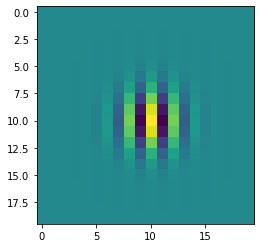

In [ ]:
gabor = create_gabor_rot_tf(Nrows=20, Ncols=20, imean=0.5, jmean=0.5, sigma_i=0.1, sigma_j=0.1, freq=10, theta=0, rot_theta=0, sigma_theta=0, fs=20)
plt.imshow(gabor)
plt.show()

## Creating a set of Gabor filters

> It can be a little bit tricky to translate plain Python `for` loops into `tf.function`.

In plain Python, if we wanted to create a set of filters we could initialize an empty array or list and fill it with the different filters generated inside a `for` loop, but we can't do that inside a `tf.function` because `Tensorflow` tries to build the computational graph and starts to nest graphs inside graphs and the performance is terrible. Luckily for us, they implement a `tf.TensorArray` that can be used inside a `tf.function` to this effect.

In [ ]:
#| export
@tf.function
def create_multiple_different_rot_gabor_tf(n_gabors, # Number of Gabor filters we want to create.
                                           Nrows, # Number of horizontal pixels.
                                           Ncols, # Number of vertical pixels.
                                           imean, # Horizontal mean *(in degrees)*.
                                           jmean, # Vertical mean *(in degrees)*.
                                           sigma_i: list, # Horizontal width *(in degrees)*.
                                           sigma_j: list, # Vertical width *(in degrees)*.
                                           freq: list, # Frequency.
                                           theta: list, # Angle.
                                           rot_theta: list, # Rotation of the domain??
                                           sigma_theta: list, # Width of the angle?? Rotation of the domain??
                                           fs, # Sampling frequency.
                                           normalize:bool = True, # Wether to normalize (and divide by n_gabors) or not the Gabors.
                                           ):
    """
    Creates a set of Gabor filters.
    """
    Nrows, Ncols, imean, jmean, sigma_i, sigma_j, freq, theta, rot_theta, sigma_theta, fs = cast_all(Nrows, Ncols, imean, jmean, sigma_i, sigma_j, freq, theta, rot_theta, sigma_theta, fs)
    gabors = tf.TensorArray(dtype = tf.float32, size = n_gabors)

    for n in tf.range(start = 0, limit = n_gabors, dtype = tf.int32):
        gabors = gabors.write(n, create_gabor_rot_tf(Nrows, Ncols, imean, jmean, tf.gather(sigma_i, n), tf.gather(sigma_j, n), tf.gather(freq, n), tf.gather(theta, n), 
                                                     tf.gather(rot_theta, n), tf.gather(sigma_theta, n), fs))

    gabors = gabors.stack()
    # gabors = tf.expand_dims(gabors, axis = -1)
    # gabors = tf.transpose(gabors, perm = [1,2,3,0])
    ## Normalize the gabors
    if normalize: 
        max_per_gabor = reduce(gabors, "n_gabors Ncols Nrows -> n_gabors () ()", "max")
        gabors = gabors/(max_per_gabor*tf.cast(n_gabors, tf.float32))
    return gabors

In [ ]:
n_gabors = 4
gabors = create_multiple_different_rot_gabor_tf(n_gabors=n_gabors, Nrows=20, Ncols=20, imean=0.5, jmean=0.5, sigma_i=[0.1]*n_gabors, sigma_j=[0.1]*n_gabors, freq=[10]*n_gabors, 
                                                theta=[0]*n_gabors, rot_theta=[0]*n_gabors, sigma_theta=[0]*n_gabors, fs=20)
gabors.shape

2022-09-22 10:36:53.962292: W tensorflow/core/framework/op_kernel.cc:1692] OP_REQUIRES failed at functional_ops.cc:374 : Internal: No function library
2022-09-22 10:36:53.963533: W tensorflow/core/framework/op_kernel.cc:1692] OP_REQUIRES failed at functional_ops.cc:374 : Internal: No function library
2022-09-22 10:36:53.964886: W tensorflow/core/framework/op_kernel.cc:1692] OP_REQUIRES failed at functional_ops.cc:374 : Internal: No function library


TensorShape([4, 20, 20])

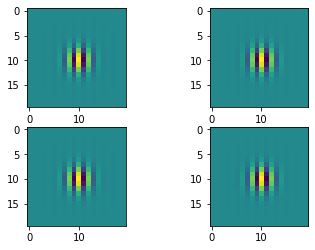

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2)
for gabor_filter, ax in zip(gabors, axes.ravel()):
    ax.imshow(gabor_filter)
plt.show()

We can, as well, change the parameters of the Gabor filters independently:

In [ ]:
n_gabors = 4
sigma_i = [0.1, 0.2, 0.3, 0.4]
sigma_j = [0.1, 0.2, 0.3, 0.4]
freq = [10, 20, 30, 40]
theta = [0, 45, 90, 135]
rot_theta = [0, 45, 90, 135]
sigma_theta = [0, 45, 90, 135]
gabors = create_multiple_different_rot_gabor_tf(n_gabors=n_gabors, Nrows=20, Ncols=20, imean=0.5, jmean=0.5, sigma_i=sigma_i, sigma_j=sigma_j, freq=freq, 
                                                theta=theta, rot_theta=rot_theta, sigma_theta=sigma_theta, fs=20)
gabors.shape

2022-09-22 10:36:55.606241: W tensorflow/core/framework/op_kernel.cc:1692] OP_REQUIRES failed at functional_ops.cc:374 : Internal: No function library
2022-09-22 10:36:55.607478: W tensorflow/core/framework/op_kernel.cc:1692] OP_REQUIRES failed at functional_ops.cc:374 : Internal: No function library
2022-09-22 10:36:55.608616: W tensorflow/core/framework/op_kernel.cc:1692] OP_REQUIRES failed at functional_ops.cc:374 : Internal: No function library


TensorShape([4, 20, 20])

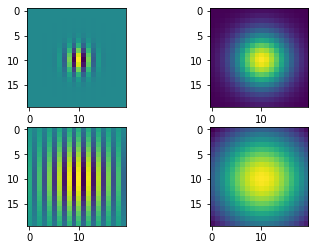

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2)
for gabor_filter, ax in zip(gabors, axes.ravel()):
    ax.imshow(gabor_filter)
plt.show()

## Gabor layer

> Gabor layer with pre-defined values.

The Gabor filters are stored in the `GaborLayer.filters` attribute and while they are re-calculated at each step of training (as should be), they are not re-calculated during inference. At inference time, the last calculated filters are used.

In [ ]:
#| export
class GaborLayer(tf.keras.layers.Layer):
    """
    Pre-initialized Gabor layer that is trainable through backpropagation.
    """
    def __init__(self,
                 n_gabors, # Number of Gabor filters
                 size, # Size of the filters (they will be square),
                 imean, # Horizontal mean *(in degrees)*.
                 jmean, # Vertical mean *(in degrees)*.
                 sigma_i: list, # Horizontal width *(in degrees)*.
                 sigma_j: list, # Vertical width *(in degrees)*.
                 freq: list, # Frequency.
                 theta: list, # Rotation of the sinusoid **(rad)**.
                 rot_theta: list, # Rotation of the domain **(rad)**.
                 sigma_theta: list, # Rotation of the envelope  **(rad)**.
                 fs, # Sampling frequency.,
                 normalize: bool = True, # Wether to normalize the Gabor filters or not.
                 **kwargs, # Arguments to be passed to the base `Layer`.
                 ):
        super(GaborLayer, self).__init__(**kwargs)

        # if len(sigma_i) != n_gabors: raise ValueError(f"sigma_i has {len(sigma_i)} values but should have {n_gabors} (n_gabors = {n_gabors}).")

        self.n_gabors = n_gabors
        self.size = size
        self.Nrows, self.Ncols = size, size
        self.fs = fs
        self.normalize = normalize

        self._check_parameter_length(sigma_i, sigma_j, freq, theta, rot_theta, sigma_theta)
        self.imean, self.jmean, self.sigma_i, self.sigma_j, self.freq, self.theta, self.rot_theta, self.sigma_theta = cast_all(imean, jmean, sigma_i, sigma_j, freq, theta, rot_theta, sigma_theta)
        
    def build(self, input_shape):

        self.imean = tf.Variable(self.imean, trainable=True, name="imean", constraint=Positive())
        self.jmean = tf.Variable(self.jmean, trainable=True, name="jmean", constraint=Positive())

        # self.sigma_i = tf.Variable(np.random.uniform(0, self.Nrows/self.fs, n_gabors), trainable=True, name="sigma_i")
        self.sigma_i = tf.Variable(self.sigma_i, trainable=True, name="sigma_i", constraint=Positive())

        # self.sigma_j = tf.Variable(np.random.uniform(0, self.Ncols/self.fs, n_gabors), trainable=True, name="sigma_j")
        self.sigma_j = tf.Variable(self.sigma_j, trainable=True, name="sigma_j", constraint=Positive())

        # self.freq = tf.Variable(np.random.uniform(0, self.fs, n_gabors), trainable=True, name="freq")
        self.freq = tf.Variable(self.freq, trainable=True, name="freq", constraint=Positive())

        # self.theta = tf.Variable(np.random.uniform(0,6, n_gabors), trainable=True, name="theta")
        self.theta = tf.Variable(self.theta, trainable=True, name="theta")

        # self.rot_theta = tf.Variable(np.random.uniform(0,6, n_gabors), trainable=True, name="rot_theta")
        self.rot_theta = tf.Variable(self.rot_theta, trainable=True, name="rot_theta")

        # self.sigma_theta = tf.Variable(np.random.uniform(0,6, n_gabors), trainable=True, name="sigma_theta")
        self.sigma_theta = tf.Variable(self.sigma_theta, trainable=True, name="sigma_theta")

        self.precalc_filters = tf.Variable(create_multiple_different_rot_gabor_tf(n_gabors=self.n_gabors, Nrows=self.Nrows, Ncols=self.Ncols, imean=self.imean, jmean=self.jmean, sigma_i=self.sigma_i, sigma_j=self.sigma_j,
                                                                                  freq=self.freq, theta=self.theta, rot_theta=self.rot_theta, sigma_theta=self.sigma_theta, fs=self.fs, normalize=self.normalize),
                                           trainable=False, name="precalc_filters")

    def _check_parameter_length(self, *args):
        for arg in args:
            if len(arg) != self.n_gabors: raise ValueError(f"Listed parameters should have the same length as n_gabors ({self.n_gabors}).")


In [ ]:
a = GaborLayer(n_gabors=n_gabors, size=20, imean=0.5, jmean=0.5, sigma_i=sigma_i, sigma_j=sigma_j, freq=freq, 
               theta=theta, rot_theta=rot_theta, sigma_theta=sigma_theta, fs=20, input_shape=(28,28,1))
# a.filters.shape

In [ ]:
#| export
@patch
def call(self: GaborLayer, 
         inputs, # Inputs to the layer.
         training=False, # Flag indicating if we are training the layer or using it for inference.
         ):
    """
    Build a set of filters from the stored values and convolve them with the input.
    """
    if training:
         gabors = create_multiple_different_rot_gabor_tf(n_gabors=self.n_gabors, Nrows=self.Nrows, Ncols=self.Ncols, imean=self.imean, jmean=self.jmean, sigma_i=self.sigma_i, sigma_j=self.sigma_j,
                                                           freq=self.freq, theta=self.theta, rot_theta=self.rot_theta, sigma_theta=self.sigma_theta, fs=self.fs, normalize=self.normalize)
         self.precalc_filters.assign(gabors)
    else:
         gabors = self.precalc_filters


    ## Keras expects the convolutional filters in shape (size_x, size_y, C_in, C_out)
    gabors = repeat(gabors, "n_gabors Ncols Nrows -> Ncols Nrows C_in n_gabors", C_in=inputs.shape[-1])
    
    return tf.nn.conv2d(inputs, gabors, strides=1, padding="SAME")

It's important to check if we can use it in a model:

In [ ]:
n_gabors = 4
sigma_i = [0.1, 0.2]*2
sigma_j = [0.2, 0.1]*2
freq = [10, 10]*2
theta = [0, np.pi/2]*2
rot_theta = [0, 0]*2
sigma_theta = [0, 0]*2

In [ ]:
model = tf.keras.Sequential([
    GaborLayer(n_gabors=n_gabors, size=20, imean=0.5, jmean=0.5, sigma_i=sigma_i, sigma_j=sigma_j, freq=freq, 
               theta=theta, rot_theta=rot_theta, sigma_theta=sigma_theta, fs=20, input_shape=(28,28,1)),
    layers.MaxPool2D(2),
    layers.GlobalAveragePooling2D(),
    layers.Dense(10, activation="softmax")
])
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gabor_layer_2 (GaborLayer)   (None, 28, 28, 4)         1626      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 4)         0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 4)                 0         
_________________________________________________________________
dense (Dense)                (None, 10)                50        
Total params: 1,676
Trainable params: 76
Non-trainable params: 1,600
_________________________________________________________________


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


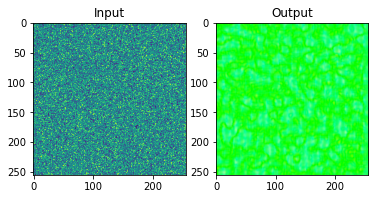

In [ ]:
n_gabors = 4
sigma_i = [0.1, 0.2, 0.3, 0.4]
sigma_j = [0.1, 0.2, 0.3, 0.4]
freq = [10, 20, 30, 40]
theta = [0, 45, 90, 135]
rot_theta = [0, 45, 90, 135]
sigma_theta = [0, 45, 90, 135]

gaborlayer = GaborLayer(n_gabors=n_gabors, size=20, imean=0.5, jmean=0.5, sigma_i=sigma_i, sigma_j=sigma_j, freq=freq, 
                        theta=theta, rot_theta=rot_theta, sigma_theta=sigma_theta, fs=20)
sample_input = np.random.uniform(0, 1, size=(1, 256, 256, 1))
sample_output = gaborlayer(sample_input).numpy()
assert sample_input.shape[1:3] == sample_output.shape[1:3]
assert sample_output.shape[-1] == 4
fig, axes = plt.subplots(1,2)
axes[0].imshow(sample_input.squeeze())
axes[1].imshow(sample_output.squeeze())
axes[0].set_title("Input")
axes[1].set_title("Output")
plt.show()

It can be helpful to implement a method to show the Gabor filters that are being used by the layer:

In [ ]:
#| export
@patch
def show_filters(self: GaborLayer):
    """
    Calculates and plots the filters corresponding to the stored parameters.
    """
    ncols = int(np.round(np.sqrt(self.n_gabors)))
    nrows = self.n_gabors - ncols
    # gabors = self.filters.numpy()
    
    try: gabors = self.precalc_filters.numpy()
    except: gabors = create_multiple_different_rot_gabor_tf(n_gabors=self.n_gabors, Nrows=self.Nrows, Ncols=self.Ncols, imean=self.imean, jmean=self.jmean, sigma_i=self.sigma_i, sigma_j=self.sigma_j,
                                                            freq=self.freq, theta=self.theta, rot_theta=self.rot_theta, sigma_theta=self.sigma_theta, fs=self.fs, normalize=self.normalize)
    fig, axes = plt.subplots(int(nrows), int(ncols))
    for gabor, ax in zip(gabors, axes.ravel()):
        ax.imshow(gabor)
    plt.show()

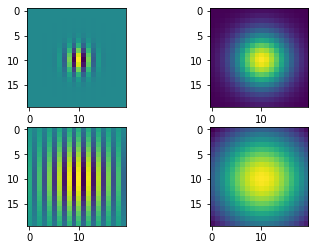

In [ ]:
gaborlayer = GaborLayer(n_gabors=n_gabors, size=20, imean=0.5, jmean=0.5, sigma_i=sigma_i, sigma_j=sigma_j, freq=freq, 
                        theta=theta, rot_theta=rot_theta, sigma_theta=sigma_theta, fs=20)
gaborlayer.show_filters()

We can check that the parameters are trainable and thus the gradient is propagated properly:

In [ ]:
gaborlayer = GaborLayer(n_gabors=n_gabors, size=20, imean=0.5, jmean=0.5, sigma_i=sigma_i, sigma_j=sigma_j, freq=freq, 
                        theta=theta, rot_theta=rot_theta, sigma_theta=sigma_theta, fs=20)

In [ ]:
gaborlayer = GaborLayer(n_gabors=n_gabors, size=20, imean=0.5, jmean=0.5, sigma_i=sigma_i, sigma_j=sigma_j, freq=freq, 
                        theta=theta, rot_theta=rot_theta, sigma_theta=sigma_theta, fs=20)
gaborlayer.build(())
with tf.GradientTape() as tape:
    output = gaborlayer(sample_input, training=True)
    loss = output - output**2
gradients = tape.gradient(loss, gaborlayer.trainable_variables)
gradients

[<tf.Tensor: shape=(), dtype=float32, numpy=-43654416.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=11970161.0>,
 <tf.Tensor: shape=(4,), dtype=float32, numpy=
 array([-4.18656562e+04, -8.09927920e+07, -1.14410117e+05, -1.23048696e+08],
       dtype=float32)>,
 <tf.Tensor: shape=(4,), dtype=float32, numpy=
 array([-4.3216855e+04, -8.0995704e+07, -1.1109711e+05, -1.2311187e+08],
       dtype=float32)>,
 <tf.Tensor: shape=(4,), dtype=float32, numpy=
 array([-8.3397627e+00, -2.5924567e+05, -1.8548600e+03, -6.3047660e+06],
       dtype=float32)>,
 <tf.Tensor: shape=(4,), dtype=float32, numpy=
 array([ 1.5471164e+00, -1.0965000e+03,  2.2201016e+03, -8.2523200e+05],
       dtype=float32)>,
 <tf.Tensor: shape=(4,), dtype=float32, numpy=
 array([-1.5463333e+00,  1.0965000e+03, -2.2200566e+03,  8.2523475e+05],
       dtype=float32)>,
 <tf.Tensor: shape=(4,), dtype=float32, numpy=array([ 0.        ,  0.5       , -0.00195312, -0.5       ], dtype=float32)>]

## Random initialize a simple set of Gabor filters

> Insted of defining ourselves the initial values, we can randomly initialize them. This can speed up our testing.

In [ ]:
#| export
@tf.function
def create_simple_random_set(n_gabors, # Number of Gabor filters we want to create.
                             size, # Size of the Gabor (they will be square).
                             ):
    """
    Creates a simple set of randomly initialized squared Gabor filters.
    """
    Nrows, Ncols = size, size
    fs = Ncols
    imean, jmean = 0.5, 0.5
    sigma_i = np.random.uniform(0, Nrows/fs, n_gabors)
    sigma_j = np.random.uniform(0, Ncols/fs, n_gabors)
    freq = np.random.uniform(0, fs, n_gabors)
    theta = np.random.uniform(0,6, n_gabors)
    rot_theta = np.random.uniform(0,6, n_gabors)
    sigma_theta = np.random.uniform(0,6, n_gabors)

    Nrows, Ncols, imean, jmean, sigma_i, sigma_j, freq, theta, rot_theta, sigma_theta, fs = cast_all(Nrows, Ncols, imean, jmean, sigma_i, sigma_j, freq, theta, rot_theta, sigma_theta, fs)
    gabors = tf.TensorArray(dtype = tf.float32, size = n_gabors)

    for n in tf.range(start = 0, limit = n_gabors, dtype = tf.int32):
        gabors = gabors.write(n, create_gabor_rot_tf(Nrows, Ncols, imean, jmean, tf.gather(sigma_i, n), tf.gather(sigma_j, n), tf.gather(freq, n), tf.gather(theta, n), 
                                                     tf.gather(rot_theta, n), tf.gather(sigma_theta, n), fs))

    gabors = gabors.stack()
    # gabors = tf.expand_dims(gabors, axis = -1)
    # gabors = tf.transpose(gabors, perm = [1,2,3,0])
    return gabors

In [ ]:
gabors = create_simple_random_set(n_gabors=4, size=20)
gabors.shape

TensorShape([4, 20, 20])

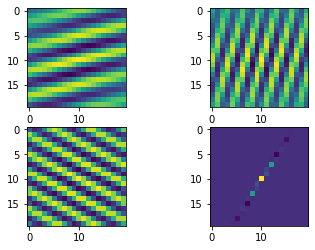

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2)
for gabor_filter, ax in zip(gabors, axes.ravel()):
    ax.imshow(gabor_filter)
plt.show()

## RandomGabor

> Actually, we can define a different layer that initializes almost all of its parameters randomly by inhereting from `GaborLayer`.

In [ ]:
#| export
class RandomGabor(GaborLayer):
    """
    Randomly initialized Gabor layer that is trainable through backpropagation.
    """
    def __init__(self,
                 n_gabors, # Number of Gabor filters.
                 size, # Size of the filters (they will be square).
                 normalize: bool = True, # Wether to normalize the Gabor filters.
                 **kwargs, # Arguments to be passed to the base `Layer`.
                 ):
        super(GaborLayer, self).__init__(**kwargs) # Hacky way of using tf.keras.layers.Layer __init__ but maintain GaborLayer's methods.
        self.n_gabors = n_gabors
        self.size = size
        self.Nrows, self.Ncols = size, size
        self.fs = self.Ncols
        self.normalize = normalize

        self.imean = 0.5
        self.jmean = 0.5
        self.sigma_i = np.random.uniform(0, self.Nrows/self.fs, self.n_gabors)
        self.sigma_j = np.random.uniform(0, self.Ncols/self.fs, self.n_gabors)
        self.freq = np.random.uniform(0, self.fs, self.n_gabors)
        self.theta = np.random.uniform(0,6, self.n_gabors)
        self.rot_theta = np.random.uniform(0,6, self.n_gabors)
        self.sigma_theta = np.random.uniform(0,6, self.n_gabors)

        super(RandomGabor, self).__init__(self.n_gabors, self.size, self.imean, self.jmean,
                                          self.sigma_i, self.sigma_j, self.freq, self.theta, self.rot_theta, self.sigma_theta, self.fs, self.normalize)

In [ ]:
gaborlayer = RandomGabor(n_gabors=4, size=20)

It's important to check if we can use it in a model:

In [ ]:
model = tf.keras.Sequential([
    RandomGabor(n_gabors=n_gabors, size=20, input_shape=(28,28,1)),
    layers.MaxPool2D(2),
    layers.GlobalAveragePooling2D(),
    layers.Dense(10, activation="softmax")
])
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
random_gabor_3 (RandomGabor) (None, 28, 28, 4)         1626      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 4)         0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 4)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                50        
Total params: 1,676
Trainable params: 76
Non-trainable params: 1,600
_________________________________________________________________


We can check that the `.call()` method from `GaborLayer` still works:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


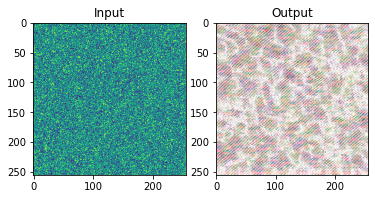

In [ ]:
gaborlayer = RandomGabor(n_gabors=4, size=20)
sample_input = np.random.uniform(0, 1, size=(1, 256, 256, 1))
sample_output = gaborlayer(sample_input).numpy()
assert sample_input.shape[1:3] == sample_output.shape[1:3]
assert sample_output.shape[-1] == 4
fig, axes = plt.subplots(1,2)
axes[0].imshow(sample_input.squeeze())
axes[1].imshow(sample_output.squeeze())
axes[0].set_title("Input")
axes[1].set_title("Output")
plt.show()

Ensure that we can still plot its filters:

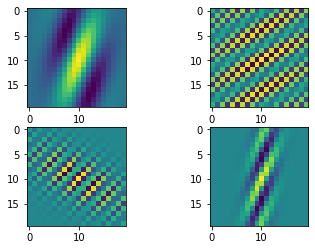

In [ ]:
gaborlayer = RandomGabor(n_gabors=4, size=20)
gaborlayer.show_filters()

We can check that the parameters are trainable and thus the gradient is propagated properly:

In [ ]:
gaborlayer = RandomGabor(n_gabors=4, size=20)
with tf.GradientTape() as tape:
    output = gaborlayer(sample_input, training=True)
    loss = output - output**2
gradients = tape.gradient(loss, gaborlayer.trainable_variables)
gradients

[<tf.Tensor: shape=(), dtype=float32, numpy=-14807149.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=310030.06>,
 <tf.Tensor: shape=(4,), dtype=float32, numpy=array([-10065.641, -68741.8  ,  -8747.457, -81285.984], dtype=float32)>,
 <tf.Tensor: shape=(4,), dtype=float32, numpy=array([-17256.184, -22176.14 , -55413.055, -26464.76 ], dtype=float32)>,
 <tf.Tensor: shape=(4,), dtype=float32, numpy=array([  7505.675, -50937.2  ,  -7013.109,  12654.501], dtype=float32)>,
 <tf.Tensor: shape=(4,), dtype=float32, numpy=
 array([   43336.797, -1755171.4  ,    85998.625, -1342648.1  ],
       dtype=float32)>,
 <tf.Tensor: shape=(4,), dtype=float32, numpy=array([ -43530.617, 1856712.   ,  -82486.6  , 1354445.6  ], dtype=float32)>,
 <tf.Tensor: shape=(4,), dtype=float32, numpy=
 array([    193.8518, -101540.625 ,   -3512.0667,  -11797.089 ],
       dtype=float32)>]